In [1]:
# make the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Identification of Cointegrated Pairs of Stocks

In [2]:
# read back the pricing data
prices = pd.read_csv('IT.csv', index_col=['date'])
prices.head(10)

INFY.NS       TCS.NS  HCLTECH.NS    WIPRO.NS    TECHM.NS  \
date                                                                      
01-01-2018  516.775024  1322.800049  439.350006  237.412552  503.100006   
02-01-2018  514.849976  1315.599976  446.399994  239.025055  513.950012   
03-01-2018  510.649994  1319.324951  448.649994  232.462555  519.450012   
04-01-2018  507.700012  1328.550049  446.549988  233.737564  522.549988   
05-01-2018  506.000000  1344.599976  450.024994  232.162552  525.450012   
08-01-2018  518.025024  1357.199951  450.250000  233.362564  536.299988   
09-01-2018  520.674988  1354.500000  446.924988  237.900055  533.849976   
10-01-2018  526.125000  1403.300049  457.924988  245.025055  542.099976   
11-01-2018  537.900024  1395.250000  458.450012  240.825058  551.700012   
12-01-2018  539.224976  1388.175049  462.950012  239.100052  550.750000   

                 LTI.NS  MINDTREE.NS  MPHASIS.NS  COFORGE.NS      LTTS.NS  
date                                                                       
01-01-2018  1145.400024   606.900024  738.250000  653.799988  1073.449951  
02-01-2018  1149.000000   605.049988  734.650024  642.549988  1105.550049  
03-01-2018  1124.800049   599.299988  720.049988  645.950012  1137.750000  
04-01-2018  1130.550049   599.900024  715.849976  653.150024  1137.900024  
05-01-2018  1108.500000   602.299988  714.000000  669.500000  1128.250000  
08-01-2018  1118.050049   632.650024  715.599976  704.049988  1111.349976  
09-01-2018  1109.050049   626.049988  712.349976  689.900024  1082.650024  
10-01-2018  1112.900024   623.849976  710.000000  719.150024  1075.300049  
11-01-2018  1118.099976   621.200012  716.200012  717.650024  1054.900024  
12-01-2018  1124.650024   633.750000  728.599976  701.299988  1043.800049

In [3]:
# train test split 
train_close, test_close = train_test_split(prices, test_size=0.251012, shuffle=False)

In [4]:
# quick view of head and tail of train set
train_close.head(2).append(train_close.tail(2))

INFY.NS       TCS.NS  HCLTECH.NS    WIPRO.NS    TECHM.NS  \
date                                                                       
01-01-2018   516.775024  1322.800049  439.350006  237.412552  503.100006   
02-01-2018   514.849976  1315.599976  446.399994  239.025055  513.950012   
30-12-2020  1246.800049  2909.300049  940.700012  384.399994  983.250000   
31-12-2020  1255.800049  2862.750000  946.150024  386.250000  973.200012   

                 LTI.NS  MINDTREE.NS   MPHASIS.NS   COFORGE.NS      LTTS.NS  
date                                                                         
01-01-2018  1145.400024   606.900024   738.250000   653.799988  1073.449951  
02-01-2018  1149.000000   605.049988   734.650024   642.549988  1105.550049  
30-12-2020  3661.149902  1629.949951  1590.400024  2694.600098  2338.649902  
31-12-2020  3659.500000  1660.349976  1539.949951  2705.149902  2339.600098

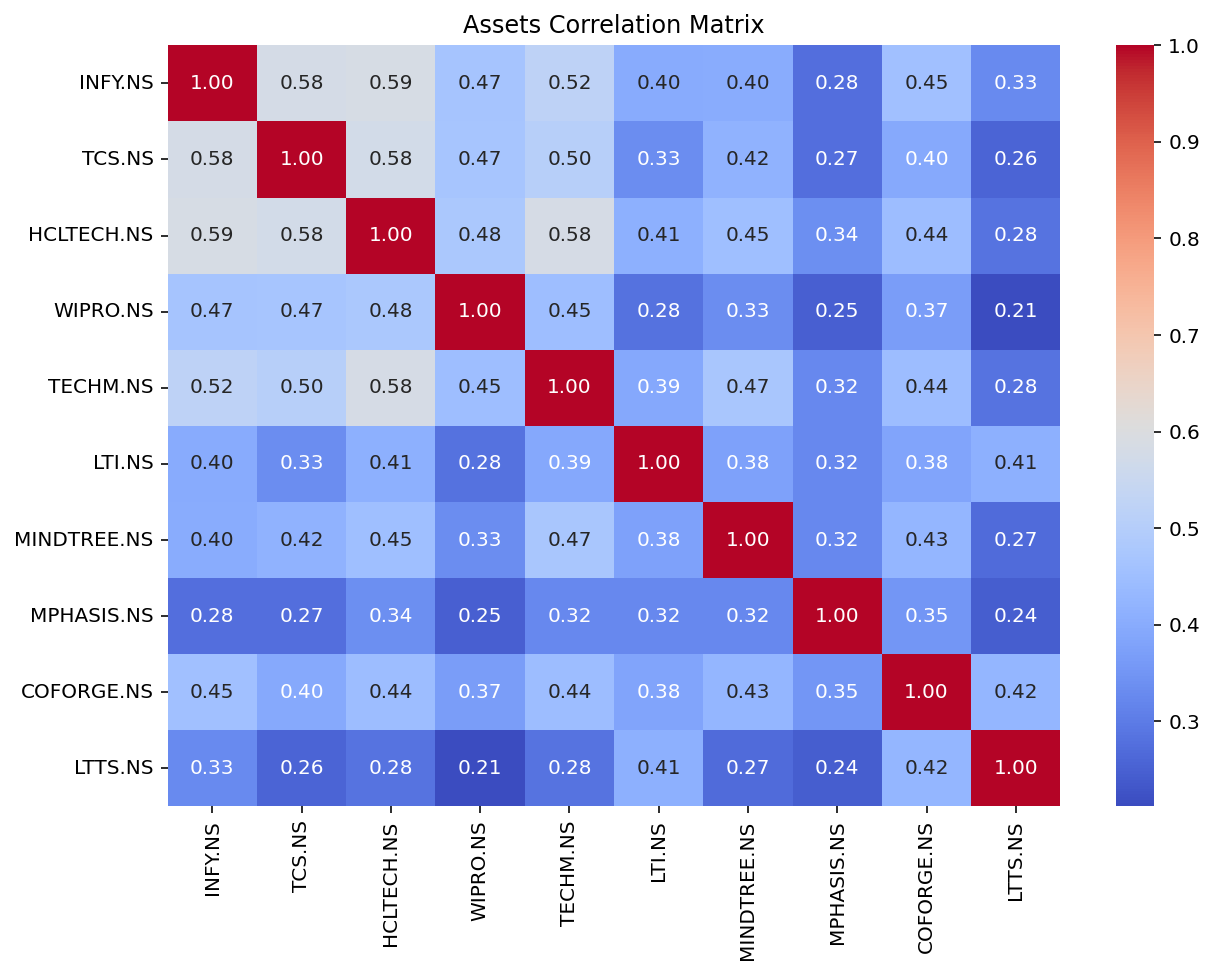

In [5]:
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')
plt.savefig('chart1', dpi=400)

In [6]:
# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

[('INFY.NS', 'HCLTECH.NS'), ('TCS.NS', 'WIPRO.NS'), ('TCS.NS', 'COFORGE.NS'), ('HCLTECH.NS', 'LTI.NS'), ('WIPRO.NS', 'LTTS.NS'), ('TECHM.NS', 'LTTS.NS')]


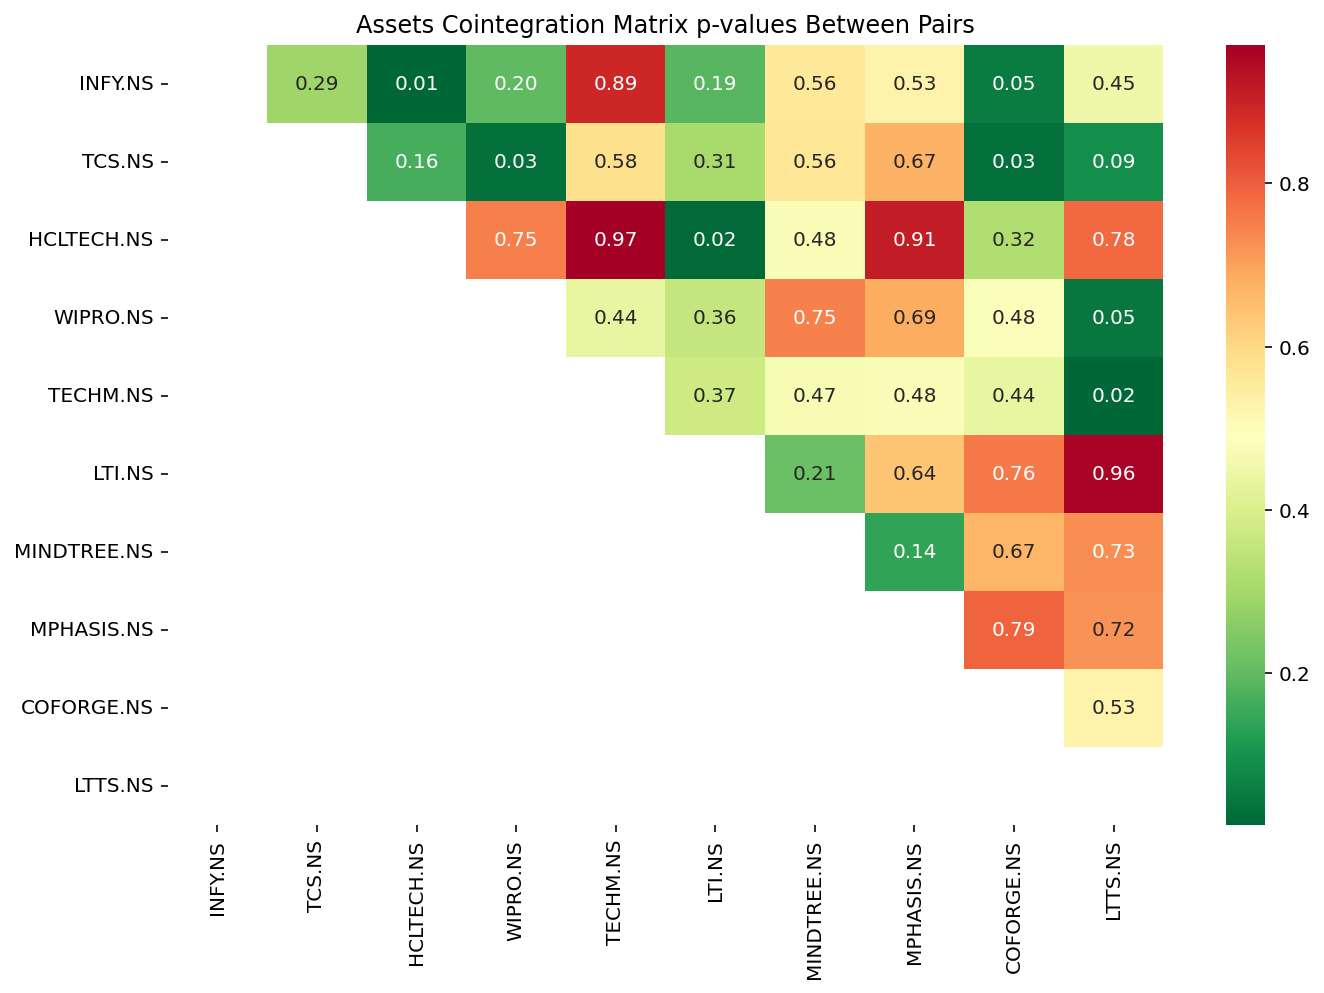

In [7]:
# calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(train_close)
print(pairs)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_close.columns,
                yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
ax.set_title('Assets Cointegration Matrix p-values Between Pairs')
plt.tight_layout()
plt.savefig('chart2', dpi=400) 

### Perform a Cointegration test for the Selected Pair

In [8]:
# final pair to test strategy
asset1 = 'INFY.NS'
asset2 = 'HCLTECH.NS'

In [9]:
# create a train dataframe of 2 assets
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]

In [10]:
from matplotlib.dates import DateFormatter
# visualize closing prices
ax = train[['asset1','asset2']].plot(figsize=(20, 10), title = 'Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing Price")
#date_form = DateFormatter("%Y")
# ax.xaxis.set_major_formatter(date_form)
ax.grid(True);
plt.savefig('chart3', dpi=400) 

In [11]:
# run OLS regression
model=sm.OLS(train.asset2, train.asset1).fit()

In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 asset2   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                          1.751e+05
Date:                Mon, 21 Mar 2022   Prob (F-statistic):                        0.00
Time:                        11:50:40   Log-Likelihood:                         -3725.7
No. Observations:                 740   AIC:                                      7453.
Df Residuals:                     739   BIC:                                      7458.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
asset1         0.7488      0.002    418.471      0.000       0.745       0.752
==============================================================================
Omnibus:                        1.163   Durbin-Watson:                   0.072
Prob(Omnibus):                  0.559   Jarque-Bera (JB):                1.235
Skew:                          -0.091   Prob(JB):                        0.539
Kurtosis:                       2.915   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
# print regression summary results
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)
plt.savefig('chart4', dpi=400);

In [14]:
print('Hedge Ratio = ', model.params[0])

Hedge Ratio =  0.7487658315775072


In [15]:
# calculate spread
spread = train.asset2 - model.params[0] * train.asset1

In [16]:
# Plot the spread
ax = spread.plot(figsize=(12, 6), title = "Pair's Spread")
ax.set_ylabel("Spread")
ax.grid(True);
plt.savefig('chart5', dpi=400);

In [17]:
# conduct Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag = 1)
adf

(-3.8216178497048556,
 0.0026937208698455486,
 0,
 739,
 {'1%': -3.439229783394421,
  '5%': -2.86545894814762,
  '10%': -2.5688568756191392},
 5484.801942812256)

In [18]:
print('Critical Value = ', adf[0])

Critical Value =  -3.8216178497048556


In [19]:
# probablity critical values
print(adf[4])

{'1%': -3.439229783394421, '5%': -2.86545894814762, '10%': -2.5688568756191392}


### Generate Trading Signals using z-score

In [20]:
# calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [21]:
# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_close[asset1] 
signals['asset2'] = test_close[asset2]
ratios = signals.asset1 / signals.asset2

In [22]:
signals.head()

asset1      asset2
date                               
01-01-2021  1260.449951  950.500000
04-01-2021  1288.250000  980.400024
05-01-2021  1293.800049  991.349976
06-01-2021  1282.099976  978.200012
07-01-2021  1262.150024  962.549988

In [23]:
# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

In [24]:
signals.head()

asset1      asset2         z  z upper limit  z lower limit
date                                                                       
01-01-2021  1260.449951  950.500000 -1.382170            1.0           -1.0
04-01-2021  1288.250000  980.400024 -1.519575            1.0           -1.0
05-01-2021  1293.800049  991.349976 -1.620924            1.0           -1.0
06-01-2021  1282.099976  978.200012 -1.557451            1.0           -1.0
07-01-2021  1262.150024  962.549988 -1.550812            1.0           -1.0

In [25]:
# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

In [26]:
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

In [27]:
# # visualize z-score and upper and lower thresholds   
signals['z'].plot(label="z Value")
plt.title("Z-score Evaluation")
plt.axhline(signals['z'].mean(),color="black")
plt.axhline(signals['z upper limit'].mean(), color="red", label="Upper Threshold")
plt.axhline(signals['z lower limit'].mean(), color="green", label="Lower Threshold")
plt.legend()
plt.tight_layout()
plt.savefig('chart6', dpi=400);

In [28]:
# verify dataframe head and tail
signals.head(3).append(signals.tail(3))

asset1       asset2         z  z upper limit  z lower limit  \
date                                                                           
01-01-2021  1260.449951   950.500000 -1.382170            1.0           -1.0   
04-01-2021  1288.250000   980.400024 -1.519575            1.0           -1.0   
05-01-2021  1293.800049   991.349976 -1.620924            1.0           -1.0   
29-12-2021  1885.550049  1291.900024  0.134602            1.0           -1.0   
30-12-2021  1892.849976  1317.050049 -0.119220            1.0           -1.0   
31-12-2021  1887.750000  1319.099976 -0.188561            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         1         NaN        -1         NaN  
04-01-2021         1         0.0        -1         0.0  
05-01-2021         1         0.0        -1         0.0  
29-12-2021         0         0.0         0         0.0  
30-12-2021         0         0.0         0         0.0  
31-12-2021         0         0.0         0         0.0

In [29]:
# # check portfolio position
signals[signals.signals1 != 0].head(10)

asset1       asset2         z  z upper limit  z lower limit  \
date                                                                           
01-01-2021  1260.449951   950.500000 -1.382170            1.0           -1.0   
04-01-2021  1288.250000   980.400024 -1.519575            1.0           -1.0   
05-01-2021  1293.800049   991.349976 -1.620924            1.0           -1.0   
06-01-2021  1282.099976   978.200012 -1.557451            1.0           -1.0   
07-01-2021  1262.150024   962.549988 -1.550812            1.0           -1.0   
08-01-2021  1312.099976   994.650024 -1.460996            1.0           -1.0   
11-01-2021  1376.199951  1055.099976 -1.629538            1.0           -1.0   
12-01-2021  1371.750000  1062.099976 -1.774892            1.0           -1.0   
13-01-2021  1387.150024  1055.949951 -1.523590            1.0           -1.0   
14-01-2021  1370.500000  1027.699951 -1.297264            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         1         NaN        -1         NaN  
04-01-2021         1         0.0        -1         0.0  
05-01-2021         1         0.0        -1         0.0  
06-01-2021         1         0.0        -1         0.0  
07-01-2021         1         0.0        -1         0.0  
08-01-2021         1         0.0        -1         0.0  
11-01-2021         1         0.0        -1         0.0  
12-01-2021         1         0.0        -1         0.0  
13-01-2021         1         0.0        -1         0.0  
14-01-2021         1         0.0        -1         0.0

In [30]:
signals[signals.positions1 != 0].head().append(signals[signals.positions1 != 0].tail())

asset1       asset2         z  z upper limit  z lower limit  \
date                                                                           
01-01-2021  1260.449951   950.500000 -1.382170            1.0           -1.0   
22-01-2021  1340.849976   985.799988 -0.994832            1.0           -1.0   
29-01-2021  1239.050049   914.000000 -1.046326            1.0           -1.0   
08-02-2021  1303.550049   957.750000 -0.984712            1.0           -1.0   
10-02-2021  1296.500000   959.450012 -1.095658            1.0           -1.0   
14-10-2021  1715.750000  1251.150024 -0.867807            1.0           -1.0   
16-11-2021  1792.300049  1163.400024  1.056016            1.0           -1.0   
24-11-2021  1696.000000  1119.449951  0.765668            1.0           -1.0   
17-12-2021  1820.849976  1171.400024  1.213476            1.0           -1.0   
21-12-2021  1811.599976  1205.000000  0.633489            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         1         NaN        -1         NaN  
22-01-2021         0        -1.0         0         1.0  
29-01-2021         1         1.0        -1        -1.0  
08-02-2021         0        -1.0         0         1.0  
10-02-2021         1         1.0        -1        -1.0  
14-10-2021         0        -1.0         0         1.0  
16-11-2021        -1        -1.0         1         1.0  
24-11-2021         0         1.0         0        -1.0  
17-12-2021        -1        -1.0         1         1.0  
21-12-2021         0         1.0         0        -1.0

In [31]:
signals.loc[signals['positions1'] == 1].index
signals['asset1'][signals['positions1'] == 1].value_counts()

1239.050049    1
1296.500000    1
1290.400024    1
1291.300049    1
1353.750000    1
1500.300049    1
1580.800049    1
1712.199951    1
1738.750000    1
1711.449951    1
1696.000000    1
1811.599976    1
Name: asset1, dtype: int64

In [32]:
signals

asset1       asset2         z  z upper limit  z lower limit  \
date                                                                           
01-01-2021  1260.449951   950.500000 -1.382170            1.0           -1.0   
04-01-2021  1288.250000   980.400024 -1.519575            1.0           -1.0   
05-01-2021  1293.800049   991.349976 -1.620924            1.0           -1.0   
06-01-2021  1282.099976   978.200012 -1.557451            1.0           -1.0   
07-01-2021  1262.150024   962.549988 -1.550812            1.0           -1.0   
...                 ...          ...       ...            ...            ...   
27-12-2021  1866.150024  1267.199951  0.283969            1.0           -1.0   
28-12-2021  1888.000000  1283.900024  0.259678            1.0           -1.0   
29-12-2021  1885.550049  1291.900024  0.134602            1.0           -1.0   
30-12-2021  1892.849976  1317.050049 -0.119220            1.0           -1.0   
31-12-2021  1887.750000  1319.099976 -0.188561            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         1         NaN        -1         NaN  
04-01-2021         1         0.0        -1         0.0  
05-01-2021         1         0.0        -1         0.0  
06-01-2021         1         0.0        -1         0.0  
07-01-2021         1         0.0        -1         0.0  
...              ...         ...       ...         ...  
27-12-2021         0         0.0         0         0.0  
28-12-2021         0         0.0         0         0.0  
29-12-2021         0         0.0         0         0.0  
30-12-2021         0         0.0         0         0.0  
31-12-2021         0         0.0         0         0.0  

[248 rows x 9 columns]

In [33]:
signals = signals.reset_index()

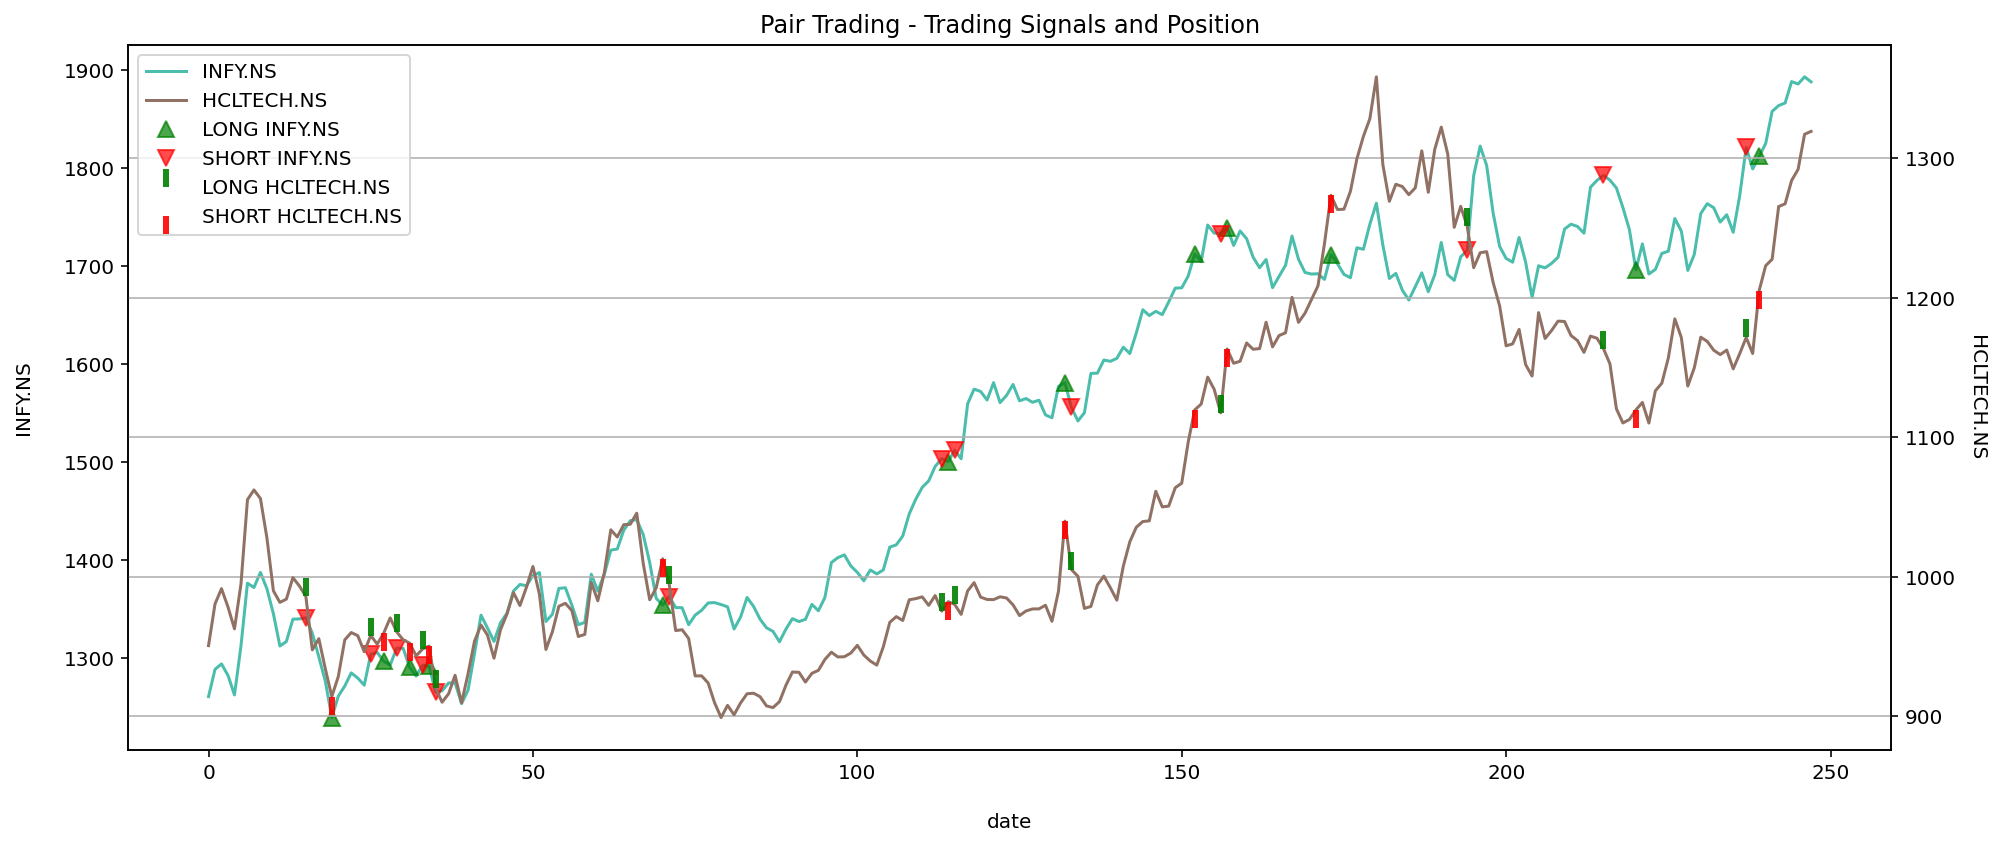

In [34]:
# visualize trading signals and position
fig=plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac')
l2, = bx2.plot(signals['asset2'], c='#907163')

u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)

bx.set_ylabel(asset1,)
bx2.set_ylabel(asset2, rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('date')
# bx.xaxis.set_major_formatter(DateFormatter("%Y"))
# bx2.xaxis.set_major_formatter(DateFormatter("%Y"))
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format(asset1),
           'SHORT {}'.format(asset1),
           'LONG {}'.format(asset2),
           'SHORT {}'.format(asset2)], loc ='best')

plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.savefig('chart7', dpi=400);

### Portfolio Profit and Loss Calculation

In [35]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

In [36]:
# since there are two assets, we calculate each asset Pnl separately 
# and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

In [37]:
portfolio.head().append(portfolio.tail())

asset1     holdings1          cash1   total asset1   return1  \
0    1260.449951           NaN            NaN            NaN       NaN   
1    1288.250000      0.000000  100000.000000  100000.000000       NaN   
2    1293.800049      0.000000  100000.000000  100000.000000  0.000000   
3    1282.099976      0.000000  100000.000000  100000.000000  0.000000   
4    1262.150024      0.000000  100000.000000  100000.000000  0.000000   
243  1866.150024 -97039.801248  166806.993708   69767.192460 -0.001971   
244  1888.000000 -98176.000000  166806.993708   68630.993708 -0.016286   
245  1885.550049 -98048.602548  166806.993708   68758.391160  0.001856   
246  1892.849976 -98428.198752  166806.993708   68378.794956 -0.005521   
247  1887.750000 -98163.000000  166806.993708   68643.993708  0.003878   

     positions1  
0           NaN  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
243         0.0  
244         0.0  
245         0.0  
246         0.0  
247         0.0

In [38]:
portfolio[portfolio.positions1 != 0].head()

asset1     holdings1          cash1   total asset1   return1  \
0   1260.449951           NaN            NaN            NaN       NaN   
15  1340.849976 -69724.198752  169724.198752  100000.000000  0.000000   
19  1239.050049      0.000000  105293.596204  105293.596204  0.018690   
25  1303.550049 -67784.602548  173078.198752  105293.596204  0.000000   
27  1296.500000      0.000000  105660.198752  105660.198752  0.004474   

    positions1  
0          NaN  
15        -1.0  
19         1.0  
25        -1.0  
27         1.0

In [39]:
# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

In [40]:
portfolio.to_csv('portfolio.csv')
portfolio.head().append(portfolio.tail())

asset1     holdings1          cash1   total asset1   return1  \
0    1260.449951           NaN            NaN            NaN       NaN   
1    1288.250000      0.000000  100000.000000  100000.000000       NaN   
2    1293.800049      0.000000  100000.000000  100000.000000  0.000000   
3    1282.099976      0.000000  100000.000000  100000.000000  0.000000   
4    1262.150024      0.000000  100000.000000  100000.000000  0.000000   
243  1866.150024 -97039.801248  166806.993708   69767.192460 -0.001971   
244  1888.000000 -98176.000000  166806.993708   68630.993708 -0.016286   
245  1885.550049 -98048.602548  166806.993708   68758.391160  0.001856   
246  1892.849976 -98428.198752  166806.993708   68378.794956 -0.005521   
247  1887.750000 -98163.000000  166806.993708   68643.993708  0.003878   

     positions1       asset2     holdings2          cash2   total asset2  \
0           NaN   950.500000           NaN            NaN            NaN   
1           0.0   980.400024      0.000000  100000.000000  100000.000000   
2           0.0   991.349976      0.000000  100000.000000  100000.000000   
3           0.0   978.200012      0.000000  100000.000000  100000.000000   
4           0.0   962.549988      0.000000  100000.000000  100000.000000   
243         0.0  1267.199951  92505.596423   45994.592043  138500.188466   
244         0.0  1283.900024  93724.701752   45994.592043  139719.293795   
245         0.0  1291.900024  94308.701752   45994.592043  140303.293795   
246         0.0  1317.050049  96144.653577   45994.592043  142139.245620   
247         0.0  1319.099976  96294.298248   45994.592043  142288.890291   

      return2  positions2  
0         NaN         NaN  
1         NaN         0.0  
2    0.000000         0.0  
3    0.000000         0.0  
4    0.000000         0.0  
243  0.001055         0.0  
244  0.008802         0.0  
245  0.004180         0.0  
246  0.013086         0.0  
247  0.001053         0.0

In [41]:
portfolio[portfolio.positions2 != 0].head()

asset1     holdings1          cash1   total asset1   return1  \
0   1260.449951           NaN            NaN            NaN       NaN   
15  1340.849976 -69724.198752  169724.198752  100000.000000  0.000000   
19  1239.050049      0.000000  105293.596204  105293.596204  0.018690   
25  1303.550049 -67784.602548  173078.198752  105293.596204  0.000000   
27  1296.500000      0.000000  105660.198752  105660.198752  0.004474   

    positions1      asset2     holdings2         cash2   total asset2  \
0          NaN  950.500000           NaN           NaN            NaN   
15        -1.0  985.799988  71963.399109  28036.600891  100000.000000   
19         1.0  914.000000      0.000000  94758.600891   94758.600891   
25        -1.0  957.750000  69915.750000  24842.850891   94758.600891   
27         1.0  959.450012      0.000000  94882.701781   94882.701781   

     return2  positions2  
0        NaN         NaN  
15  0.000000         1.0  
19 -0.015136        -1.0  
25  0.000000         1.0  
27  0.006076        -1.0

In [42]:
# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

In [43]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()

l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)

b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')

ax.set_ylabel('Portfolio Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');
plt.savefig('chart8', dpi=400);

In [44]:
#portfolio = pd.read_csv('portfolio.csv')

In [45]:
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
final_portfolio

210932.88399899995

In [46]:
profit = final_portfolio - 2*initial_capital
profit

10932.883998999954

In [47]:
roi = (profit/(2*initial_capital))*100
roi

5.466441999499977

In [48]:
# delta = (portfolio.index[-1] - portfolio.index[0]).days
delta = (portfolio.index[-1] - portfolio.index[0])
print('Number of days = ', delta)

Number of days =  245


In [49]:
YEAR_DAYS = 365
returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

CAGR = 204.025%
